## Modelagem de topicos através do tempo

In [ ]:
%pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import unicodedata
from umap import UMAP
from hdbscan import HDBSCAN
import os
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
comments = pd.read_csv("comments_filtered.csv")
print(comments[['created_timestamp_utc']].head())
comments['month'] = pd.to_datetime(comments['created_timestamp_utc']).dt.to_period('M').astype(str)
comments['type'] = 'C'

date_month_com = comments['month']

  created_timestamp_utc
0   2022-01-01 19:16:14
1   2022-01-01 19:16:20
2   2022-01-01 20:33:19
3   2022-01-01 23:30:43
4   2022-01-02 01:08:38


In [ ]:
submissions = pd.read_csv("submissions_filtered.csv")
print(submissions[['created_timestamp_utc']].head())
submissions['month'] = pd.to_datetime(submissions['created_timestamp_utc']).dt.to_period('M').astype(str)
submissions['type'] = 'S'

date_month_sub = submissions['month']

  created_timestamp_utc
0   2022-01-13 11:42:41
1   2022-01-18 17:36:20
2   2022-01-19 02:58:23
3   2022-01-19 21:07:55
4   2022-01-22 13:39:24


In [ ]:
# concatenate the two numpy arrays
date_month = pd.concat([date_month_com, date_month_sub], ignore_index=True)

print(date_month.value_counts().sort_index())


month
2022-01    1077
2022-02    9436
2022-03    9458
2022-04    2158
2022-05    2944
2022-06    1480
2022-07    1513
2022-08    1036
2022-09    2166
2022-10    2627
2022-11    2204
2022-12    1484
Name: count, dtype: int64


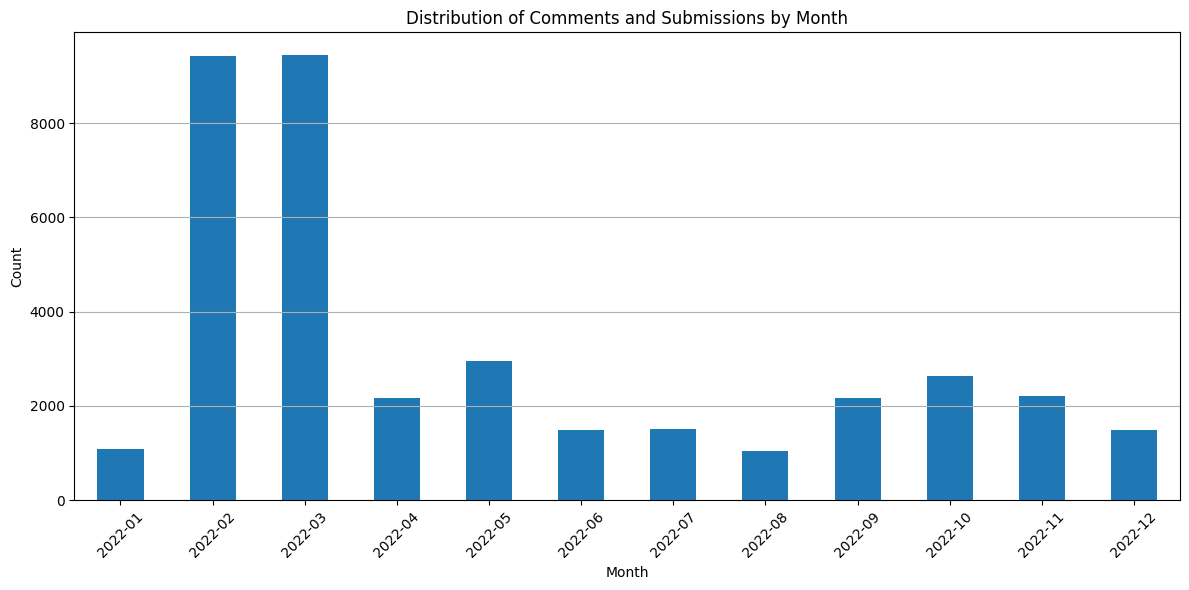

In [ ]:
# plot distribution of comments and submissions by month
date_month.value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Comments and Submissions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
data_comments = comments[['id', 'body', 'month', 'type']].rename(columns={'body': 'text', 'month': 'date'})
print(data_comments.head())
print(data_comments.shape)
data_submissions = submissions[['id', 'selftext', 'month', 'type']].rename(columns={'selftext': 'text', 'month': 'date'})
print(data_submissions.head())
print(data_submissions.shape)

# concatenate the two dataframes
data = pd.concat([data_comments, data_submissions], ignore_index=True)
data.columns = ['id', 'text', 'month', 'type']
print(data.head())
print(data.shape)

        id                                               text     date type
0  hqu6678  Eu não coloco a tua experiência em causa, mas ...  2022-01    C
1  hqu66rn  &gt;Farmaajo tem sido apoiado por muito tempo ...  2022-01    C
2  hquhhht  O que é dar certo? Porque pensa bem, o país er...  2022-01    C
3  hqv6rub  O embargo é dos EUA. Eles podem fazer negócios...  2022-01    C
4  hqvk4xj  a Ucrânia voltar ao seu estado natural de naçã...  2022-01    C
(36854, 4)
       id                                               text     date type
0  s2xl48  Conclamo meus colegas redditors a ouvirem/vere...  2022-01    S
1  s72yze  \- Apoio a Russia. Lutaria se pedissem.   \n\-...  2022-01    S
2  s7fnwt  Olhem o vídeo, por exemplo, de uma matéria fal...  2022-01    S
3  s80kun   Só pra saber q eu n sou o único vendo isso!? ...  2022-01    S
4  sa2q4t  Na internet já vi vários comentários de ucrani...  2022-01    S
(729, 4)
        id                                               text    month typ

In [ ]:
print(stopwords.words('portuguese')[:30])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles']


### Pre-process

In [ ]:
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8")

    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    return text.strip()

data['text'] = data['text'].apply(preprocess_text)

### Pre-calculate embeddings

In [ ]:
docs = data['text'].tolist()
timestamps = data['month'].tolist()

embeddings_path = "embeddings.npy"

if os.path.exists(embeddings_path):
    embeddings = np.load(embeddings_path)
    print("Embeddings carregadas do disco.")
else:
    embedding_model = SentenceTransformer("PORTULAN/serafim-100m-portuguese-pt-sentence-encoder")
    embeddings = embedding_model.encode(docs, show_progress_bar=True)
    np.save(embeddings_path, embeddings)
    print("Embeddings calculadas e salvas no disco.")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Batches:   0%|          | 0/1175 [00:00<?, ?it/s]

Embeddings calculadas e salvas no disco.


### Stopwords and vectorizer

In [ ]:
stopwords_pt = list(stopwords.words("portuguese"))
# apply the same preprocessing to the stopwords
stopwords_pt = [preprocess_text(word) for word in stopwords_pt]
stopwords_en = list(stopwords.words("english"))
my_stopwords = ['pra', 'gt', 'vai', 'ta', 'pq', 'vc']
final_stopwords = stopwords_pt + stopwords_en + my_stopwords


vectorizer = CountVectorizer(
    ngram_range=(1,2),
    stop_words=final_stopwords,
    max_df=0.8,
    min_df=1
)

### UMAP Dimension Reduction

In [ ]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=13
)

### HDBSCAN clustering

In [ ]:
hdbscan_model = HDBSCAN(
    min_cluster_size=500,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
)

In [ ]:
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    calculate_probabilities=True,
    umap_model=umap_model,
    hdbscan_model= hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

2025-07-06 01:44:04,482 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-06 01:45:50,899 - BERTopic - Dimensionality - Completed ✓
2025-07-06 01:45:50,905 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-06 01:46:38,712 - BERTopic - Cluster - Completed ✓
2025-07-06 01:46:38,730 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-06 01:46:53,727 - BERTopic - Representation - Completed ✓


In [ ]:
### value counts of topics
print(pd.Series(topics).value_counts().sort_index())

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)

12it [05:46, 28.85s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time)

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.get_representative_docs(0)

In [ ]:
topic_model.get_representative_docs(1)

In [ ]:
topic_model.get_representative_docs(2)

['imprimiram dinheiro para salvar corporacoes e para criarem creditos para que as pessoas mantivessem consumindo  aliviando a crise \n\nimprimir dinheiro nao causa inflacao  o que causa inflacao e excesso de demanda para uma estrutura de oferta limitada  escacess  \n\nimprimir dinheiro pode tanto criar excesso de consumo ou pode criar excesso de oferta em financiando meios produtivos e distribution  como infra estrutura   e nesse segundo caso a impressao de dinheiro causa deflacao  o que ja e um outro problema que cria outra crise por desestimular consumo \n\ne se o dinheiro nao parar na nao do consumidor mas se restringir as corporacoes  o dinheiro nao circulado nao gera aumento de consumo que possa criar inflacao \n\nveja o exemplo da inflacao atual nos eua  nao foi a impressao de dinheiro que criou a inflacao mas sim o sucateamento em investimento em infra estrutura  sendo meio que privatizado nos servicos de empresas como amazon e redes de supermercados  entre outros  e a falta de 

In [ ]:
topic_model.get_representative_docs(3)

['nao sei rick  parece falso \n\nmas seria engracado se a russia invadisse de vez e a nato nao so sentasse no protocolo \n\nbom que o ocidente acaba logo e passamos do inferno mediano para a desgraca absurdo de uma vez',
 'atacar  hauehaudhwhdhe\n\nrussia nao financiou guerra ne amigo  nao provocou desestabilizacao politica \n\nocidente bad\n\na proposito  sou calejado de celso furtado  prebisch e literatura cepalina  nao que isso faca meu argumento mais forte',
 'o imperio frances acha que o norte da africa e deles  os eua achm que o oriente medio e deles  so todos lixos imperialistas\n\na unica mneira de impedir esses imperios e criticando e expondo a injustic dessas invasoes  mas ficar fazendo whataboutlism pro russia hj e a unica coisa que nao vai prejudicar os imperios genocidas']

In [ ]:
topic_model.get_representative_docs(4)

In [ ]:
topic_model.get_representative_docs(5)

## Q3 - Análise das relações dos tópicos com cada Subreddit

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)

12it [05:43, 28.61s/it]


In [ ]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"alem, etc, dinheiro, presidente, fala",677,2022-01-01
1,0,"ucraniano, ucranianos, nazista, invadir ucrani...",226,2022-01-01
2,1,"presidente, biden, falou, lider, pau cu",81,2022-01-01
3,2,"ouro, gas, valioso, preco, bitcoin",76,2022-01-01
4,3,"briga contra, outros outros, cazaquistao, esco...",17,2022-01-01
5,-1,"presidente, ucraniano, etc, ucranianos, alem",4706,2022-02-01
6,0,"ucraniano, ucranianos, presidente, nazista, uc...",3593,2022-02-01
7,1,"presidente, pro putin, ditador, biden, fala",631,2022-02-01
8,2,"gas, preco, mercado, dinheiro, fertilizantes",352,2022-02-01
9,3,"invadir pais, invadir brasil, tao ostensiva, o...",154,2022-02-01


Frequência dos tópicos por Subreddit, bruta e normalizada (# tópico/todos os tópicos)

In [ ]:
if 'subreddit' not in data.columns:
    comments_subreddit = comments[['id', 'subreddit']]
    submissions_subreddit = submissions[['id', 'subreddit']]
    subreddit_data = pd.concat([comments_subreddit, submissions_subreddit], ignore_index=True)
    data = pd.merge(data, subreddit_data, on='id', how='left')

data['topic_label'] = topics
display(data.head())

,id,text,month,type,topic,subreddit,topic_label
0,hqu6678,eu nao coloco a tua experiencia em causa mas ...,2022-01,C,-1,brasil,-1
1,hqu66rn,gt farmaajo tem sido apoiado por muito tempo p...,2022-01,C,-1,brasil,-1
2,hquhhht,o que e dar certo porque pensa bem o pais er...,2022-01,C,-1,brasil,-1
3,hqv6rub,o embargo e dos eua eles podem fazer negocios...,2022-01,C,2,brasil,2
4,hqvk4xj,a ucrania voltar ao seu estado natural de naca...,2022-01,C,0,brasil,0


In [ ]:
raw_topic_frequencies = data.groupby(['subreddit', 'topic_label']).size().unstack(fill_value=0)
display(raw_topic_frequencies)

topic_label,-1,0,1,2,3
subreddit,,,,,
botecodoreddit,54,21,8,2,1
brasil,11672,7596,1500,1133,292
brasilivre,6994,3543,849,816,185
conversas,156,22,4,2,2
desabafos,580,208,36,35,3
eu_nvr,66,28,5,3,2
futebol,880,298,68,24,16
investimentos,209,35,12,167,5
saopaulo,25,5,2,4,1


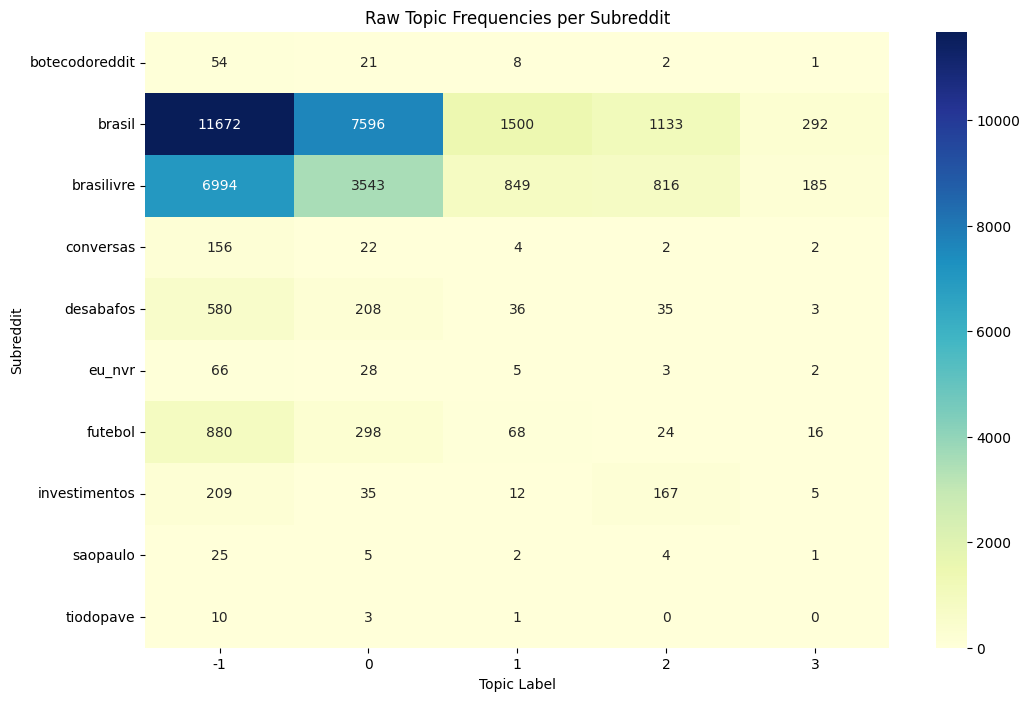

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(raw_topic_frequencies, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Raw Topic Frequencies per Subreddit')
plt.xlabel('Topic Label')
plt.ylabel('Subreddit')
plt.show()

**Reasoning**:
Normalize the raw topic frequencies by dividing each row by its sum to get proportions and then display the result.



In [ ]:
normalized_topic_frequencies = raw_topic_frequencies.div(raw_topic_frequencies.sum(axis=1), axis=0)
display(normalized_topic_frequencies.head())

topic_label,-1,0,1,2,3
subreddit,,,,,
botecodoreddit,0.627907,0.244186,0.093023,0.023256,0.011628
brasil,0.525932,0.342270,0.067589,0.051052,0.013157
brasilivre,0.564624,0.286026,0.068540,0.065876,0.014935
conversas,0.838710,0.118280,0.021505,0.010753,0.010753
desabafos,0.672854,0.241299,0.041763,0.040603,0.003480


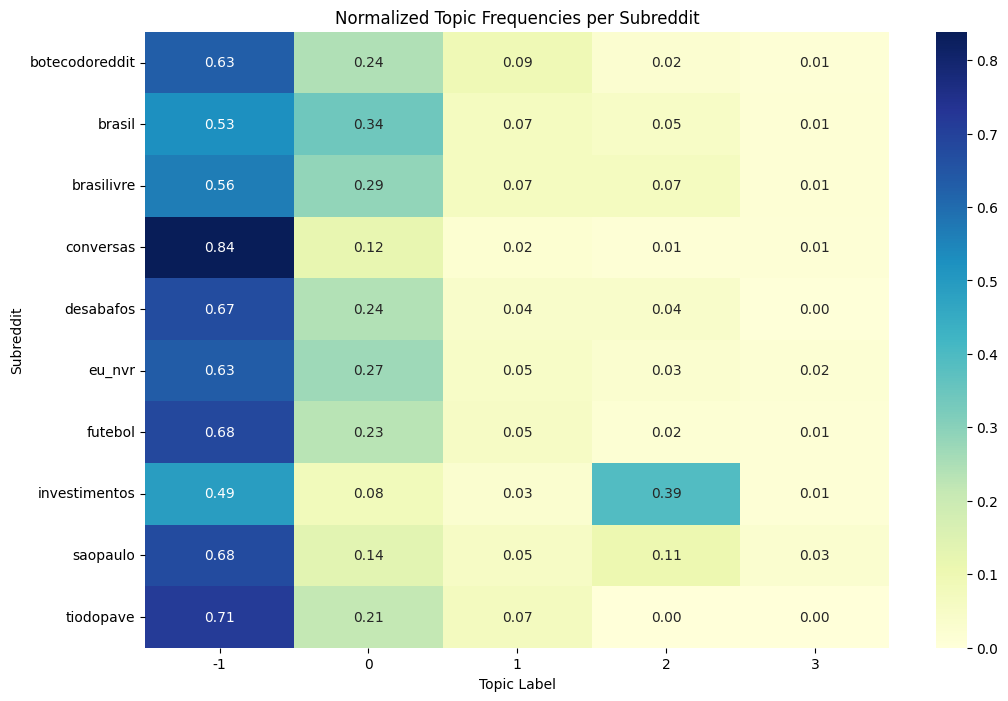

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_topic_frequencies, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Topic Frequencies per Subreddit")
plt.xlabel("Topic Label")
plt.ylabel("Subreddit")
plt.show()